In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import rasterio as rio
from scipy import stats
import shapely as shp
from shapely.geometry import Point
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.polynomial.polynomial import polyfit
from scipy import interpolate
from scipy.ndimage import gaussian_filter1d
from coasty import postprocess
from scipy import stats

In [2]:
# params
crs = "EPSG:3857"                   # coordinate system code of a projected crs 
data_dir = os.path.join(os.getcwd(),"data")
plot_dir = os.path.join(os.getcwd(),"figures/plots")

coastal_blue = "#074e67"
coastal_turquoise = "#05878a"
coastal_beige = "#b6af9d"
coastal_orange = "#ff8f7a"
coastal_grey = "#d7ccc8"

plt.rcParams["font.size"] = 11

In [24]:
# calc sample Otsu 
from rasterio.plot import show
from skimage.filters import threshold_otsu

# show shoreline only as contours
test_raster_path = os.path.join(data_dir,"P09/P09_2002_09avg_aq_bin.tif")
with rio.open(test_raster_path,"r") as src:
    image = src.read(1)
    test_otsu = threshold_otsu(image[~np.isnan(image)])

    print(test_otsu)

0.001953125


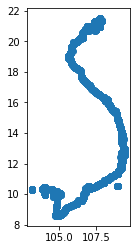

In [87]:
# modification of sandy beaches dataset!
df = pd.read_csv("/Users/Ronjamac/Downloads/Ronja_Lappe/VNM_annual_coastlinesnewdatabase.csv",sep=";",decimal=",")
geometry = [Point(xy) for xy in zip(df.Intersect_lon, df.Intersect_lat)]
df = df.drop(['Intersect_lon', 'Intersect_lat'], axis=1)
gdf = gpd.GeoDataFrame(df, crs="EPSG:4326", geometry=geometry)
gdf.to_file("/Users/Ronjamac/Downloads/Ronja_Lappe/VNM_annual_coastlinesnewdatabase.geojson",driver="GeoJSON")
gdf.plot()

In [72]:
# show transect method (without smoothing)
from coasty import postprocess
    
def draw_transects_polygon(gdf, length_l, length_r, distance, min_line_length,sigma=3,out_path_poly=None):
    """Create transects perpendicular to a polygons outline. The shape of the
    the polygon is smoothed using a Gaussian Filter (Sigma: 3)

    Args:
        gdf (GeoDataFrame): Geopandas GeoDataFrame with Polygons or Multipolygons
        length (int): Length of transects in m
        distance (int): Distance between transects in m 
        min_line_length (min): Minimum length of the polygon line to generate transects at (e.g. to remove islands)
        sigma (int, optional): Sigma value for Gaussian filter to smooth the polygon outlines. Defaults to 3.
        out_path_poly (string, optional): Path to save the smoothed polygon, if not defined polygon won't be saved 
            or returned. Defaults to None.

    Returns:
        GeoDataFrame: Geopandas GeoDataFrame with transects as LineStrings 
    """
    crs = gdf.crs
    all_transects = []
    if type(gdf.geometry.iloc[0]) == shp.geometry.multipolygon.MultiPolygon:
        print("Yes I'm multiple, sorry.")      
        gdf = gdf.explode().reset_index(drop=True)
    polygons = []
    for index, row in gdf.iterrows():
        poly = row.geometry
        if poly.length > min_line_length:
            n_points = int(poly.length/distance)
            print(index, "n_points:", n_points)        
            new_xy = np.transpose([poly.exterior.interpolate(t).xy for t in np.linspace(0,poly.length,n_points,False)])[0]
            x = new_xy[0]
            y = new_xy[1]
            # number of points where to interpolate MultiPolygon
            t1 = np.linspace(0, 1, len(x))
            t2 = np.linspace(0, 1, n_points)
            #x2 = gaussian_filter1d(x, sigma)
            #y2 = gaussian_filter1d(y, sigma)
            # interpolate on smoothed line
            x3 = np.interp(t1, t2, x)
            y3 = np.interp(t1, t2, y)
            new_points = np.array([[x, y] for x, y in zip(x3, y3)])
            new_polygon = shp.geometry.asPolygon(new_points)
            polygons.append(new_polygon)
            transects = []
            for index, point in enumerate(new_points): 
                if index+1 < len(new_points):
                    a = new_points[index]
                    b = new_points[index+1]
                    ab = shp.geometry.LineString([a,b])
                    if not ab.length == 0:
                        left = ab.parallel_offset(length_l,'left')
                        right = ab.parallel_offset(length_r,'right')
                        if not left.is_empty and not right.is_empty:
                            c = left.boundary[1]
                            d = right.boundary[0]  # note the different orientation for right offset
                            cd = shp.geometry.LineString([c,d])
                            transects.append(cd)
            transects_gdf = gpd.GeoDataFrame(geometry=transects,crs=crs)
            all_transects.append(transects_gdf)
        else:
            print("Noop")
    all_polygons_gdf = gpd.GeoDataFrame(geometry=polygons,crs=crs)
    if out_path_poly is not None:
        all_polygons_gdf.to_file(out_path_poly,driver="GeoJSON")
    all_transects_gdf = pd.concat(all_transects,ignore_index=True)
    all_transects_gdf['id'] = all_transects_gdf.index
    return all_transects_gdf

country_bounds = gpd.read_file("/home/ronja/Documents/Master_thesis/Code/VN_coastline_dynamics/data/VN_country_bounds_gov")
country_bounds = country_bounds.to_crs(crs)
country_bounds['area'] = country_bounds.geometry.area
country_bounds = country_bounds[country_bounds.area == np.max(country_bounds.area)]
transects = draw_transects_polygon(country_bounds,1500,1500,200,10000,0)
transects.to_file("/home/ronja/Documents/Master_thesis/Code/VN_coastline_dynamics/data/VN_transects_gov_notSmoothed",driver="GeoJSON")

Yes I'm multiple, sorry.
0 n_points: 98
1 n_points: 94
2 n_points: 116
3 n_points: 674
4 n_points: 163
5 n_points: 109
6 n_points: 75
7 n_points: 108
8 n_points: 148
9 n_points: 100
10 n_points: 100
11 n_points: 339
12 n_points: 265
13 n_points: 106
14 n_points: 138
15 n_points: 97
16 n_points: 146
17 n_points: 89
18 n_points: 98
19 n_points: 98
20 n_points: 233
21 n_points: 173
22 n_points: 105
23 n_points: 312
24 n_points: 168
Noop
Noop
27 n_points: 56
28 n_points: 121
29 n_points: 90
30 n_points: 77
Noop
Noop
Noop
Noop
Noop
Noop
37 n_points: 76
38 n_points: 110
39 n_points: 88
Noop
Noop
Noop
Noop
44 n_points: 300
Noop
46 n_points: 154
47 n_points: 104
48 n_points: 148
49 n_points: 93
50 n_points: 150
51 n_points: 84
52 n_points: 79
53 n_points: 78
54 n_points: 112
55 n_points: 128
56 n_points: 76
Noop
58 n_points: 57
59 n_points: 63
60 n_points: 75
Noop
62 n_points: 92
63 n_points: 106
Noop
Noop
66 n_points: 88
Noop
Noop
69 n_points: 114
70 n_points: 76
71 n_points: 137
72 n_points:

IsADirectoryError: [Errno 21] Is a directory: '/home/ronja/Documents/Master_thesis/Code/VN_coastline_dynamics/data/VN_transects_gov_notSmoothed'

In [7]:
# extract transect origin points
transects_path = os.path.join(os.path.join(os.getcwd(),"shared_data/validation/validation_transects"))
transects = gpd.read_file(transects_path)
transects = transects.explode()
origin_points = []
for i, transect in transects.iterrows():
    transect = transect.geometry
    origin = shp.geometry.Point(transect.coords[1])
    origin_points.append(origin)
origins_gdf = gpd.GeoDataFrame(geometry=origin_points,crs=crs)
origins_gdf = origins_gdf.to_crs(crs)
origins_gdf.to_file(transects_path+"_origins",driver="GeoJSON")
print("Done!")

Done!


### Test analyze classification transects (24.05)

In [3]:
VN_intersections = gpd.read_file(os.path.join(os.getcwd(),"data","VN_all_intersections"))
VN_classifications = gpd.read_file(os.path.join(data_dir,"VN_all_classifications"))
transects = gpd.read_file(os.path.join(data_dir,"VN_transects_gov_2km_200m_clip"))

/home/ronja/anaconda3/envs/geo_env/lib/python3.9/site-packages/geopandas/geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


In [8]:
transects.index

RangeIndex(start=0, stop=18715, step=1)

In [20]:
sample_transects = []
numbers = [2718, 2491, 16695,3150,7612]

#numbers = [2719, 2492, 16696,3151] #intersections transect id +1
for i in numbers:
    sample_transects.append(transects[transects.index==i])
sample_transects_gdf = pd.concat(sample_transects)#gpd.GeoDataFrame(geometry=sample_transects,crs=transects.crs)
sample_transects_gdf.to_file(os.path.join(data_dir,"sample_transects"),driver="GeoJSON")

45.39860594866175
10.671854470205929
-38.843400757510544
-40.33559519041494
-0.022978944011423065


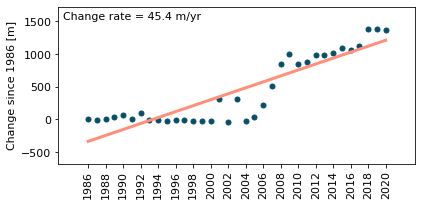

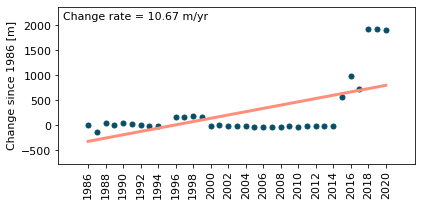

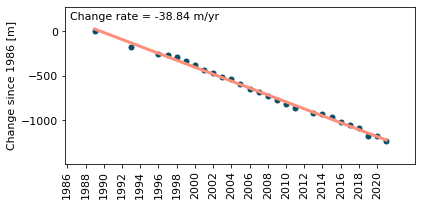

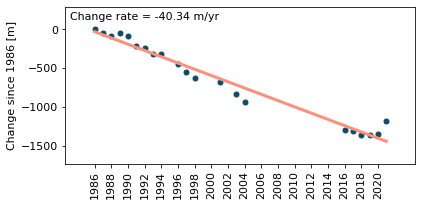

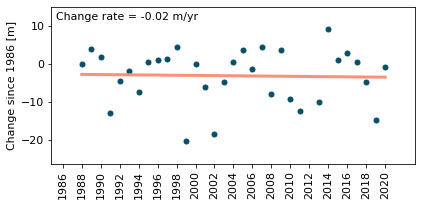

In [22]:
import warnings
warnings.filterwarnings('ignore')

years = np.arange(1986,2022,step=2)
# plot regression of a specific transect 
numbers = [2718, 2491, 16695,3150,7612]
for t in numbers:
    inter = VN_intersections[VN_intersections["transect_id"]==t]
    inter['year'] = inter['year'].astype(int)#[int(y) for y in inter.year]
    min_year = inter[inter.year == np.min(inter.year)]
    inter = VN_intersections[VN_intersections["transect_id"]==t]
    inter['change'] = inter.dist_to_transect_origin-np.min(min_year.dist_to_transect_origin)
    #reg = stats.linregress(inter.year, inter.change)
    slope = VN_classifications[VN_classifications.Transect_id == t].LRR_slope.iloc[0]
    print(slope)
    x = np.array(inter.year).astype(int)#np.array(range(len(inter)))
    y = inter.change
    b, m = polyfit(x=x, y=y,deg=1)
    fig,ax = plt.subplots(figsize=(6,3))
    ax.plot(np.array(inter.year).astype(int), inter.change,".",markersize=10,color=coastal_blue)
    ax.plot(x,b+m*x,"-",lw=3, color=coastal_orange)
    plt.xticks(years)
    ax.set_xticklabels(years, rotation=90)
    ax.margins(x=0.1,y=0.2)
    ax.set_ylabel("Change since 1986 [m]")
    ax.annotate("Change rate = "+str(slope.round(2))+" m/yr",xy=(0,1),xycoords="axes fraction",xytext=(5,-5), textcoords="offset points",ha="left",va="top")
    fig.tight_layout()
    fig.savefig(os.path.join(plot_dir,"Transect_TS_"+str(t)), dpi=400)

17711
69.4955986934567 -0.30503423995032874
17712
84.11976904064585 -0.593856938978969
17714
15.150348841761646 -0.21294330915191953
17736
125.09713610508146 0.06399935756083128


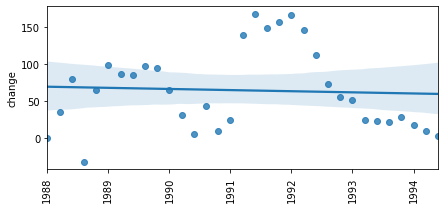

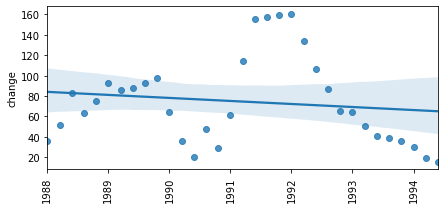

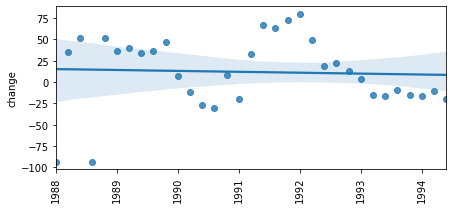

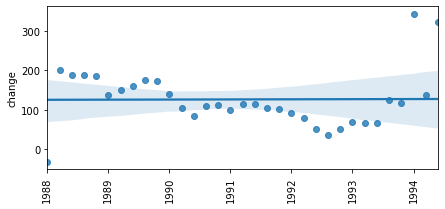

In [222]:
# plot regressions along transects of a specfic class 
complex = VN_classifications[VN_classifications["class_L1"]=="Complex"]
for t in complex["Transect_id"][1:5]:
    print(t)
    inter['year'] = inter['year'].astype(int)#[int(y) for y in inter.year]
    min_year = inter[inter.year == np.min(inter.year)]
    inter = VN_intersections[VN_intersections["transect_id"]==t]
    inter['change'] = inter.dist_to_transect_origin-np.min(min_year.dist_to_transect_origin)
    inter_median = np.median(inter.change)
    inter_std =  np.std(inter.change)
    inter = inter[inter.change.map(lambda x: abs(x-inter_median))<abs(3*inter_std)] 
    
    x = np.array(range(len(inter)))
    y = inter.change
    b, m = polyfit(x=x, y=y,deg=1)
    print(b,m)
    fig,ax = plt.subplots(figsize=(7,3))
    sns.regplot(x=x,y=inter.change,ax=ax)
    #ax.plot(inter.year, inter.change,".",markersize=10)
    #ax.plot(x,b+m*x,"-",lw=3)
    ax.set_xticklabels(inter.year, rotation=90)

In [ ]:
# per province (with dict - not used, but keep for sample dict code)#
# create dictionary with provinces keys and class L1 values
prov_dict = {p[1].ADM1_EN: dict(gpd.clip(VN_classifications, p[1].geometry)["class_L1"].value_counts(normalize=True) * 100) for p in coastal_provinces.iterrows()}
# group dicionary 
grouped_dict = {key: [] for key in prov_dict[list(prov_dict)[0]].keys()}
province_names = sorted(list(prov_dict.keys()))
for province in province_names:
    for key in grouped_dict.keys():
        try:
            grouped_dict[key] = np.hstack([np.float32(grouped_dict[key]), prov_dict[province][key]])
        except KeyError:
            grouped_dict[key] = np.hstack([np.float32(grouped_dict[key]), [0]])
# plot
fig, ax = plt.subplots(figsize=(10,10))
bars1 = grouped_dict['Erosion']
bars2 = grouped_dict['Accretion']
bars4 = grouped_dict['No change']
bars3 = grouped_dict['Complex']
ax.barh(province_names,bars1,color=coastal_orange)
ax.barh(province_names,bars2,left=bars1,color=coastal_blue)
ax.barh(province_names,bars3,left=bars1+bars2,color=coastal_turquoise)
ax.barh(province_names,bars4,left=bars1+bars2+bars3,color=coastal_beige)

In [23]:
# draw circles around hotspots
severe_erosion_hotspots = gpd.read_file(os.path.join(data_dir,"VN_extreme_accretion_hotspots_grouped"))
centroids = []
for i, transects in severe_erosion_hotspots.iterrows():
    centroids.append(transects.geometry.centroid)
centroids_gdf = gpd.GeoDataFrame(geometry=centroids, crs = severe_erosion_hotspots.crs)
centroids_gdf['length'] = severe_erosion_hotspots.length
centroids_gdf['LRR_slope'] = severe_erosion_hotspots.LRR_slope
centroids_gdf.to_file(os.path.join(data_dir,"VN_extreme_accretion_hotspots_points"),driver="GeoJSON")
severe_erosion_hotspots

,cluster_no,LRR_slope,LRR_stderr,EPR,Number_of_transects,Length,index_right,ADM1_EN,geometry
0,5,13.032463,5.838017,14.761550,47,9400,21,Quang Ninh,"MULTILINESTRING ((12009265.935 2452405.225, 12..."
1,6,12.349050,3.234717,3.117231,30,6000,21,Quang Ninh,"MULTILINESTRING ((11995877.015 2445277.475, 11..."
2,7,7.861675,2.213313,4.299192,38,7600,21,Quang Ninh,"MULTILINESTRING ((11991055.513 2440736.199, 11..."
3,8,11.002357,4.837675,6.836435,30,6000,21,Quang Ninh,"MULTILINESTRING ((11978930.034 2430000.467, 11..."
4,9,15.241942,1.725774,12.132930,60,12000,21,Quang Ninh,"MULTILINESTRING ((11957002.381 2398018.342, 11..."
5,10,6.466186,0.878025,6.166861,29,5800,21,Quang Ninh,"MULTILINESTRING ((11951521.733 2396935.899, 11..."
6,11,36.781793,3.172929,31.106290,79,15800,21,Quang Ninh,"MULTILINESTRING ((11944039.699 2390905.621, 11..."
7,12,25.310524,2.478236,22.715732,63,12600,21,Quang Ninh,"MULTILINESTRING ((11936910.976 2391054.978, 11..."
8,13,11.477232,0.951813,9.202748,47,9400,21,Quang Ninh,"MULTILINESTRING ((11918710.497 2386666.948, 11..."
9,14,21.088199,2.517124,16.900702,57,11400,21,Quang Ninh,"MULTILINESTRING ((11909438.274 2386618.603, 11..."


In [51]:
# draw convex hull around transects 
severe_accretion_hotspots = gpd.read_file(os.path.join(data_dir,"VN_extreme_accretion_hotspots_grouped"))
cluster_numbers = list(severe_accretion_hotspots.cluster_no)
hulls = []
for i in cluster_numbers:
    gdf = severe_erosion_hotspots[severe_erosion_hotspots.cluster_no == i]
    hull = gdf.unary_union.convex_hull
    hulls.append(hull)
hulls_gdf = gpd.GeoDataFrame(geometry=hulls,crs=severe_accretion_hotspots.crs)
hulls_gdf.to_file(os.path.join(data_dir,"test_hulls"),driver="GeoJSON")

In [54]:
VN_shorelines = gpd.read_file(os.path.join(data_dir,"VN_all_shorelines"))
shorelines_hull = gpd.clip(VN_shorelines,hulls_gdf)

/home/ronja/anaconda3/envs/geo_env/lib/python3.9/site-packages/geopandas/geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


In [55]:
shorelines_hull.to_file(os.path.join(data_dir,"VN_all_shorelines_erosion_hotspots"),driver="GPKG")